# Text mining tweets

This example uses HealthX's tweets.

### Load tweets into a json file

In [ ]:
import tweepy
import config 
import json
from tweepy import OAuthHandler

auth = OAuthHandler(config.ckey,config.csecret)
auth.set_access_token(config.atoken,config.asecret)
api = tweepy.API(auth)

num_tweets = 2000                    # number of tweets to retrieve
twitter_id = 'healthx_africa'     # userid 

file_name = 'healthXtweets.json'
output = open(file_name,"w")
for tweet in tweepy.Cursor(api.user_timeline, id=twitter_id).items(num_tweets):
    output.write(json.dumps(tweet._json)+'\n') 
output.close()


### Parse json into a dataframe

In [ ]:
import json
import pandas as pd

def load_tweets(file):
    with open(file,'r') as f:
        tweets = (json.loads(line) for i, line in enumerate(f.readlines()))
    return tweets

# Select the attributes needed
data = {'text': [], 'created_at': [], 'retweet_count': [], 'favorite_count': [], 'followers_count': []}
        
tweets = load_tweets(file_name)
for t in tweets:
    data['text'].append(t['text'])
    data['retweet_count'].append(t['retweet_count'])
    data['created_at'].append(t['created_at'])
    data['favorite_count'].append(t['favorite_count'])
    data['followers_count'].append(t['user']['followers_count'])
    
df = pd.DataFrame(data)
df['created_at'] = pd.to_datetime(df['created_at']) # convert to datetime data type
df.sort_values(by='created_at'); # suppress output (works in notebook)

### Looking at Favorite and Retweet Counts

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

% matplotlib inline
plt.style.use('ggplot')

In [ ]:
df_stacked = df.loc[:,('favorite_count','retweet_count')]

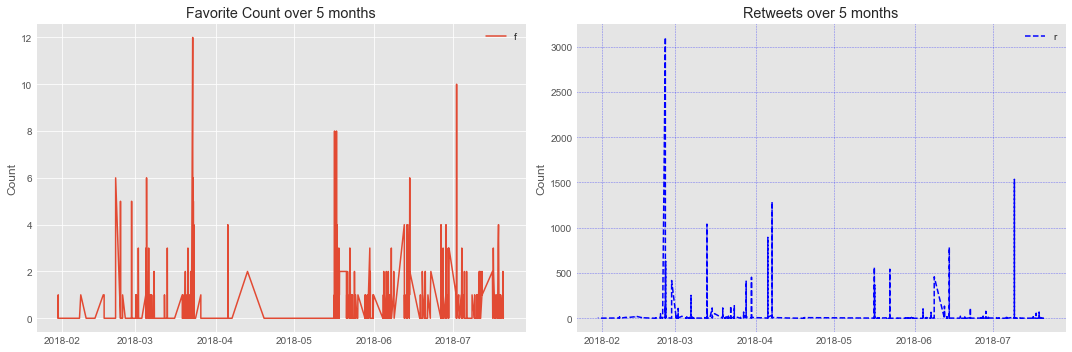

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
num_days = (max(df['created_at']) - min(df['created_at'])).days
num_months = int(num_days/30)

# default grid appearance
axes[0].plot(df['created_at'],df['favorite_count'],label='favorite count')
axes[1].plot(df['created_at'],df['retweet_count'],label='retweet count',ls="--",color='b')

axes[0].set_title(('Favorite Count over ' + str(num_months) + ' months'))
axes[1].set_title(('Retweets over ' + str(num_months) + ' months'))

axes[0].grid(True)
axes[1].grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)

axes[0].yaxis.set_label_text('Count')
axes[1].yaxis.set_label_text('Count')
axes[0].legend('favorites')
axes[1].legend('retweets')
plt.tight_layout()

## HealthX_Africa's top 10 tweets

In [124]:
top_ten_tweets = df['favorite_count'].sort_values(ascending=False).head(10) # returns a df with first column = index, second column = tweet

print(twitter_id + "'s top 10 tweets (using favorite count)" + "\n")
for i in range(10):
    index = top_ten_tweets.index[i]
    print(str(i+1) + ")" + df.iloc[index]['text'])
    print("Favorite count: " + str(df.iloc[index]['favorite_count']) + "\n")


healthx_africa's top 10 tweets (using favorite count)

1)now counting hours healthx meet panelist i interested key drivers lasting health chang
Favorite count: 12

2)auditing innovationsforhealth important it goes without saying people using
Favorite count: 10

3)are developing innovationsforhealth interested showcasing there opportunity n
Favorite count: 8

4)despite benefits bigdata iot etc make decisions use information data
Favorite count: 8

5)if serious uhc mobilising domestic resources uhc critical im kenyans driven
Favorite count: 6

6)what next uhc kenya 23 march 2018 brought ek consulting strathmore business school
Favorite count: 6

7)universal health coverage one big four agenda what now how kenya implement who key ac
Favorite count: 6

8)despite benefits bigdata iot etc make decisions use information data
Favorite count: 6

9)just 2 hrs left 1st healthx looking friday plan join dr stella bosire our 4th panelist represent
Favorite count: 5

10)indeed big 4 specific affordab

### Word Frequency

#### Remove Stop words and **RT**

In [125]:
import re
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [126]:
def text_process(title):
    """"
    1.remove punc
    2.remove stopwords
    3.return array of cleaned text.
    """
    nopunc = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(http.?://[^\s]+[\s]?)"," ",title).split()
    clean_txt = ' '.join([word for word in nopunc if word not in stopwords.words('english')]).lower()

    return clean_txt

In [127]:
df['text'] = df['text'].apply(text_process)


In [128]:
word_series = pd.Series(' '.join(df['text']).lower().split()) 
top_freq = word_series.value_counts()[:5]

### Plot Most frequent Words

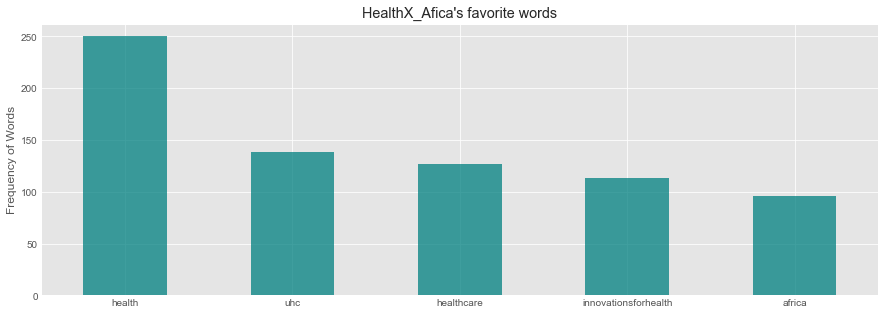

In [129]:
plt.figure(figsize=(15,5))
plt.title("HealthX_Afica's favorite words")

N = 20
word_freq = pd.Series(filt).value_counts()[:5]           # top 10 words

# sns.barplot(x=,y=,word_freq)

top_freq.plot(kind='bar',color='teal',alpha=0.75, rot=0)                             # how to rotate ticks?
# plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.show()

### Account Activity

In [ ]:
ind_df = df.set_index('created_at') 
ind_df = ind_df.groupby(pd.TimeGrouper(freq='W')).count().loc[:,'text'] # group by weeks, count, and extract a series
trim_df = ind_df.iloc[1:len(ind_df)-1] # trim first/last week to ensure we show data collected from full weeks

plt.figure(figsize=(15,5))
plt.title(twitter_id + "'s Account Activity")
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.plot(trim_df)
plt.show()